In [1]:
# select the cellxgene environment

# download example data
!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

2024-01-05 12:58:21 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


In [2]:
# Downloading the fine-tuned Geneformer model
# get model link
import cellxgene_census
import json

census = cellxgene_census.open_soma(census_version="2023-12-15")

geneformer_info = census["census_data"]["homo_sapiens"].ms["RNA"].obsm["geneformer"].metadata
geneformer_info = json.loads(geneformer_info["CxG_embedding_info"])
geneformer_info["model_link"]

's3://cellxgene-contrib-public/models/geneformer/2023-12-15/homo_sapiens/fined-tuned-model/'

In [9]:
# download via aws
#aws profile aws s3 ls --profile AdministratorAccess-654654151369
!/w5home/bmoore/bin/aws s3 sync s3://cellxgene-contrib-public/models/geneformer/2023-12-15/homo_sapiens/fined-tuned-model/ ./fine_tuned_geneformer  --no-progress --only-show-errors --profile AdministratorAccess-654654151369

In [25]:
# load more packages
import warnings

warnings.filterwarnings("ignore")

from transformers import BertForSequenceClassification
from transformers import Trainer
from geneformer import DataCollatorForCellClassification
from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor
from cellxgene_census.experimental import get_embedding
from cellxgene_census.experimental.ml.huggingface import GeneformerTokenizer
import datasets
import json
import os
import scanpy as sc
import numpy as np
import cellxgene_census
import tiledbsoma

In [26]:
# prep test data: #
## Set the index as the ENSEMBL ID and stores it in the obs column "ensembl_id"
## Add read counts to the obs column "n_counts"
## Add an ID column to be used for joining later in the obs column "joinid"

adata = sc.read_10x_mtx("/w5home/bmoore/data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

h5ad_dir = "/w5home/bmoore/data/h5ad/"

if not os.path.exists(h5ad_dir):
    os.makedirs(h5ad_dir)

adata.write(h5ad_dir + "pbmcs.h5ad")

In [2]:
os.getcwd()

'/mnt/isi5home/bmoore/Gamm_scRNAseq/src'

In [27]:
# tokenize the test data using Geneformer’s tokenizer
token_dir = "/w5home/bmoore/data/tokenized_data/"

if not os.path.exists(token_dir):
    os.makedirs(token_dir)

tokenizer = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid"})
tokenizer.tokenize_data(
    data_directory=h5ad_dir,
    output_directory=token_dir,
    output_prefix="pbmc",
    file_format="h5ad",
)

Tokenizing /w5home/bmoore/data/h5ad/pbmcs.h5ad
/w5home/bmoore/data/h5ad/pbmcs.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Saving the dataset (1/1 shards): 100%|██████████| 2700/2700 [00:00<00:00, 102334.30 examples/s]


In [28]:
# prepare the data from the model
model_dir = "/w5home/bmoore/fine_tuned_geneformer/"
label_mapping_dict_file = os.path.join(model_dir, "label_to_cell_subclass.json")

with open(label_mapping_dict_file, "r") as fp:
    label_mapping_dict = json.load(fp)

In [29]:
label_mapping_dict

{'0': 'B cell',
 '1': 'BEST4+ intestinal epithelial cell, human',
 '2': 'CD4-positive, alpha-beta T cell',
 '3': 'CD8-positive, alpha-beta T cell',
 '4': 'CNS neuron (sensu Vertebrata)',
 '5': 'GABAergic neuron',
 '6': 'T cell',
 '7': 'abnormal cell',
 '8': 'adventitial cell',
 '9': 'animal cell',
 '10': 'bone cell',
 '11': 'cardiocyte',
 '12': 'cell of skeletal muscle',
 '13': 'ciliated cell',
 '14': 'columnar/cuboidal epithelial cell',
 '15': 'connective tissue cell',
 '16': 'contractile cell',
 '17': 'defensive cell',
 '18': 'dendritic cell',
 '19': 'duct epithelial cell',
 '20': 'ecto-epithelial cell',
 '21': 'ectodermal cell',
 '22': 'endo-epithelial cell',
 '23': 'endocrine cell',
 '24': 'endothelial cell',
 '25': 'epithelial cell',
 '26': 'epithelial cell of lung',
 '27': 'epithelial cell of pancreas',
 '28': 'epithelial cell of urethra',
 '29': 'eukaryotic cell',
 '30': 'exocrine cell',
 '31': 'fat cell',
 '32': 'fibroblast',
 '33': 'germ cell',
 '34': 'glandular epithelial cel

In [30]:
# Loading tokenized data
dataset = datasets.load_from_disk(token_dir + "pbmc.dataset")
dataset

Dataset({
    features: ['input_ids', 'joinid', 'length'],
    num_rows: 2700
})

In [31]:
# add a label column
dataset
dataset = dataset.add_column("label", [0] * len(dataset))

In [9]:
import accelerate
accelerate.__version__
#


'0.25.0'

In [10]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.4192, 0.1541, 0.1077],
        [0.4762, 0.5345, 0.9351],
        [0.8370, 0.7880, 0.4993],
        [0.4251, 0.9255, 0.0218],
        [0.4932, 0.2603, 0.5633]])


In [11]:
import geneformer

In [32]:
# load model and run inference
# 1 GPU recommended
# reload pretrained model
model = BertForSequenceClassification.from_pretrained(model_dir)
# create the trainer
trainer = Trainer(model=model, data_collator=DataCollatorForCellClassification())
# use trainer
predictions = trainer.predict(dataset)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
# select most likely class
predicted_label_ids = np.argmax(predictions.predictions, axis=1)
predicted_labels = [label_mapping_dict[str(i)] for i in predicted_label_ids]

In [14]:
# Inspect results
# add predicted labels to anndata
adata.obs["predicted_cell_subclass"] = predicted_labels

In [15]:
# Do normalization, variable genes, scaling, pca, nearest enighbors and umap to visualize results
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

In [17]:
!pip3 install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.7 MB/s eta 0:00:00:00:01


In [18]:
# add original labels to compare
sc.tl.leiden(adata)
original_cell_types = [
    "CD4-positive, alpha-beta T cell (1)",
    "CD4-positive, alpha-beta T cell (2)",
    "CD14-positive, monocyte",
    "B cell (1)",
    "CD8-positive, alpha-beta T cell",
    "FCGR3A-positive, monocyte",
    "natural killer cell",
    "dendritic cell",
    "megakaryocyte",
    "B cell (2)",
]
adata.rename_categories("leiden", original_cell_types)

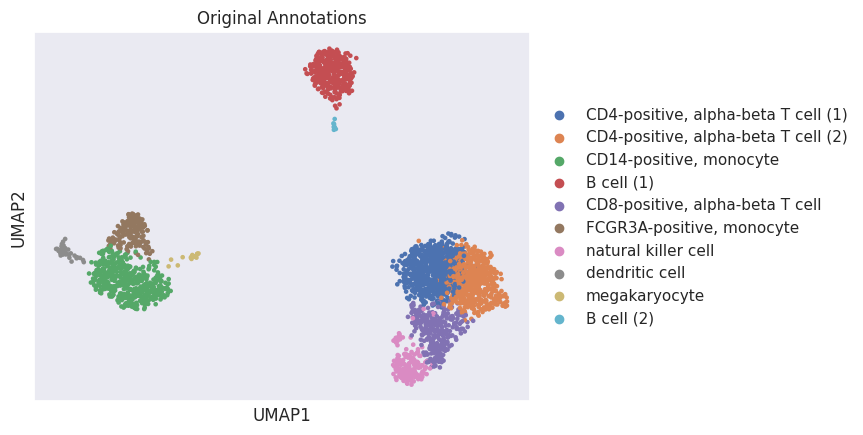

In [19]:
# visualize original labels
sc.pl.umap(adata, color="leiden", title="Original Annotations")

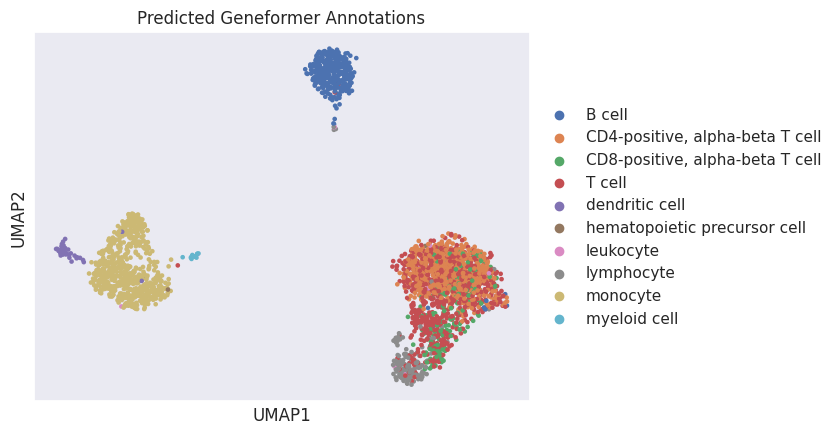

In [20]:
# visualize predictions
sc.pl.umap(adata, color="predicted_cell_subclass", title="Predicted Geneformer Annotations")


In [23]:
# Using the Geneformer fine-tuned model for data projection
# Generating Geneformer embeddings for 10X PBMC 3K data
# This projects new data into the cEnsus embedding space from the fine-tuned model

# get number of cell subsclases present in the model
n_classes = len(label_mapping_dict)
cell_types = set(label_mapping_dict.values())
cell_types

{'B cell',
 'BEST4+ intestinal epithelial cell, human',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'CNS neuron (sensu Vertebrata)',
 'GABAergic neuron',
 'T cell',
 'abnormal cell',
 'adventitial cell',
 'animal cell',
 'bone cell',
 'cardiocyte',
 'cell of skeletal muscle',
 'ciliated cell',
 'columnar/cuboidal epithelial cell',
 'connective tissue cell',
 'contractile cell',
 'defensive cell',
 'dendritic cell',
 'duct epithelial cell',
 'ecto-epithelial cell',
 'ectodermal cell',
 'endo-epithelial cell',
 'endocrine cell',
 'endothelial cell',
 'epithelial cell',
 'epithelial cell of lung',
 'epithelial cell of pancreas',
 'epithelial cell of urethra',
 'eukaryotic cell',
 'exocrine cell',
 'fat cell',
 'fibroblast',
 'germ cell',
 'glandular epithelial cell',
 'glial cell',
 'glutamatergic neuron',
 'hematopoietic cell',
 'hematopoietic precursor cell',
 'hepatocyte',
 'inflammatory cell',
 'interneuron',
 'interstitial cell',
 'ionocyte',
 'kidney cel

In [24]:
# run the EmbExtractor
# 1 GPU recommended
output_dir = "data/geneformer_embeddings"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=n_classes,
    max_ncells=None,
    emb_label=["joinid"],
    emb_layer=0,
    forward_batch_size=30,
    nproc=8,
)

embs = embex.extract_embs(
    model_directory=model_dir,
    input_data_file=token_dir + "pbmc.dataset",
    output_directory=output_dir,
    output_prefix="emb",
)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx